## Monte Carlo Control

In [1]:
import sys
sys.path.append("..")
from scripts.k_armbed_bandit.functions import moving_average

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for visualization of animation
from PIL import Image
from matplotlib import animation
from IPython.display import HTML

# RL gymnasium
import gymnasium as gym
from gymnasium import spaces
import pygame

from copy import deepcopy
import warnings
warnings.filterwarnings("ignore")

In [2]:
class Race(gym.Env):
    def __init__(self, 
                 race_track, # race track grid - 0 for track, 1 for start, 2 for goal, 3 for barrier
                 velocity_cap, # max absolute value
                ):

        # entire race track
        self.race_track = race_track

        # get track
        self.track = np.argwhere(self.race_track == 0)
        self.track = [tuple(i) for i in self.track]        

        # get starting points
        self.start_coords = np.argwhere(self.race_track == 1)
        self.start_coords = [tuple(i) for i in self.start_coords]
        
        # get end points
        self.end_coords = np.argwhere(self.race_track == 2)
        self.end_coords = [tuple(i) for i in self.end_coords]

        # get barriers
        self.barriers = np.argwhere(self.race_track == 3)
        self.barriers = [tuple(i) for i in self.barriers]

        # velocity cap
        self.velocity_cap = velocity_cap

        # We have 9 actions, for velocity changes (-1, 0, +1) for each (x, y)
        self.action_space = spaces.Discrete(9)

        """
        The following dictionary maps abstract actions from `self.action_space` to
        """

        self._action_to_velocity_delta = {
                    0: (0, 0), # (x, y) velocity changes
                    1: (0, 1),
                    2: (0, -1),
                    3: (1, 0),
                    4: (-1, 0),
                    5: (1, -1),
                    6: (-1, 1),
                    7: (-1, -1),
                    8: (1, 1),
                }
        
        # back to start at the very beginning and initialize velocity
        self._back_to_start()

    def _get_obs(self):
        return {"agent": self._agent_location}

    def _get_info(self):
        return {"velocity": self._agent_velocity,
                "next_state": self._agent_next_location, # predicted next location
                }
    
    # place agent back to start (if barrier is hit) or env is reset
    def _back_to_start(self):
        # Choose the agent's location uniformly at random
        j = np.random.choice(range(len(self.start_coords)))
        self._agent_location = self.start_coords[j] # random location on any of the start of the track

        # agent velocity is 
        self._agent_velocity = [0, 0] # reset to 0
        self._agent_next_location = self._agent_location # initialize next location

    def reset(self, seed=None, options=None):

        # We need the following line to seed self.np_random
        # this resets the environment?
        super().reset(seed=seed)
        
        self._back_to_start()

        observation = self._get_obs()
        info = self._get_info()

        return observation, info
    
    def step(self, action):
        # Map the action (element of {0,1,2,3...}) to the velocity
        self.velocity_delta = self._action_to_velocity_delta[action]

        # update velocity
        self._agent_velocity[0] = self._agent_velocity[0] + self.velocity_delta[0]
        self._agent_velocity[1] = self._agent_velocity[1] + self.velocity_delta[1]

        # clip velocity so it is never negative? # THIS IS SUTTON'S PROBLEM !!!
        # but maybe we can skip this for now to make it more versatile!!
        # Cap velocity to have absolute value of <= velocity_cap
        self._agent_velocity[0] = np.clip(self._agent_velocity[0],
                                       -self.velocity_cap, self.velocity_cap)
        self._agent_velocity[1] = np.clip(self._agent_velocity[1],
                                       -self.velocity_cap, self.velocity_cap)  

        # velocity must not be (0, 0)
        if tuple(self._agent_velocity) == (0, 0):
            a = np.random.choice(range(1, 9)) # excluding 0
            self._agent_velocity = np.array(self._action_to_velocity_delta[action]) # just get a random action

        # anticipate the next location --  THIS IS WHAT WE USE FOR REWARD COMPUTATION
        self._agent_next_location = [self._agent_location[0] + self._agent_velocity[0], 
                                     self._agent_location[1] + self._agent_velocity[1]]        

        # note not yet terminated
        terminated = False

        # if next location is outside the track, then go back to start!!
        if tuple(self._agent_next_location) in self.barriers:
            self._back_to_start()

        # if next location is in the Finish Area then awesome -- just make the finish area large
        elif tuple(self._agent_next_location) in self.end_coords:
            terminated = True

        # otherwise update location
        else:
            self._agent_location = self._agent_next_location

        # An episode is done iff the agent has reached the target - in the Finish area
        reward = -1 # always -1 reward!
        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, False, info
    
    def render(self):
        race_track_viz = deepcopy(self.race_track)
        race_track_viz[self._agent_location[0], self._agent_location[1]] = 4

        return race_track_viz

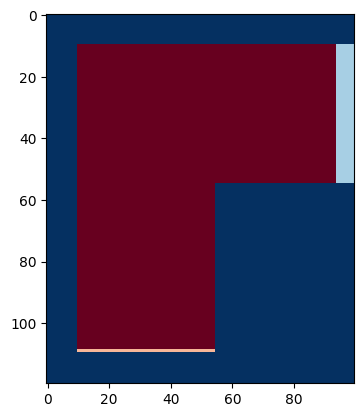

In [39]:
h = 120
w = 100
racecar_track = np.ones((h, w)) * 3

racecar_track[:, 10:55] = 0
racecar_track[10:55, 55:] = 0
racecar_track[:10, :] = 3
racecar_track[-10:, :] = 3

# for i in range(racecar_track.shape[0]):
#     for j in range(racecar_track.shape[1]):
#         if np.sin(i/20) < np.tan(j/40) + 1 and np.sin(i/20) > np.tan(j/40):
#             racecar_track[(i, j)] = 0

#         if (i-100)**2 + (j-100) **2 < 50**2:
#             racecar_track[(i, j)] = 0        

#         if (i-100)**2 + (j-100) **2 < 30**2:
#             racecar_track[(i, j)] = 3

#         # if np.sin(i/20) < np.tan(j/40) + 1 and np.sin(i/20) > np.tan(j/40):

#         if j < 40:                            
#             racecar_track[(i, j)] = 3

#         if i > 194:
#             racecar_track[(i, j)] = 3

j_start = np.argwhere(racecar_track[h-10-1, :] == 0)
j_finish = np.argwhere(racecar_track[:, w-6:] == 0)

for j in j_start:
    racecar_track[h-10-1, :][tuple(j)] = 1

for j in j_finish:
    racecar_track[:, w-6:][tuple(j)] = 2

plt.imshow(racecar_track, cmap='RdBu')

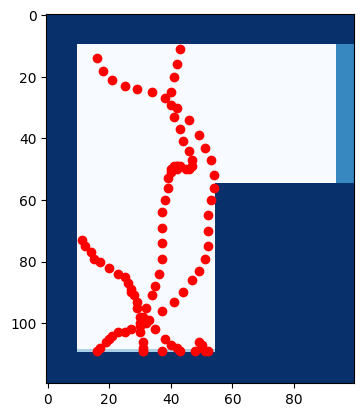

In [43]:
env = Race(race_track=racecar_track, velocity_cap=5)
env.reset()

agent_locs = []
for i in range(100):
    a = np.random.choice(range(9))
    observation, reward, terminated, _, info = env.step(a)
    if terminated:
        env.reset()
    if i % 1 == 0:
        agent_locs += [env._agent_location]

# MC Control
agent_locs = np.array(agent_locs)
plt.imshow(racecar_track, cmap='Blues')
plt.scatter(agent_locs[:, 1], agent_locs[:, 0], c='r', marker='o')

In [44]:
class MC:
    def __init__(self, env):
        self.env = env
        self.Q, self.state_map = self.init_Q_C(init_val=0)
        self.C, _ = self.init_Q_C(init_val=0)
    
    def init_Q_C(self, init_val):

        actions_list = list(self.env._action_to_velocity_delta.values())
        states = self.env.track + self.env.start_coords + self.env.end_coords

        state_map = {}

        Q = np.ones(shape=(len(states), len(actions_list)))
        for s in range(len(states)):
            for a in range(len(actions_list)):
                if init_val == 'normal':
                    Q[s, a] = np.random.normal()
                else:
                    Q[s, a] = init_val # optimistic starts

                state_map[states[s]] = s

        self.actions_list = actions_list

        return Q, state_map

    def pi(self, s, eps):

        s_idx = self.state_map[s]
        assert type(s_idx) == int

        explore = np.random.choice([True, False], p=[eps, 1-eps])

        if explore:
            a = np.random.choice(range(self.Q.shape[1]))

        else:
            # greedy. randomly break ties
            a = np.random.choice(np.argwhere(self.Q[s_idx, :] == max(self.Q[s_idx, :])).flatten())

        return a
    
    def generate_trajectory(self, eps):

        self.env.reset()
        observation = self.env._get_obs()['agent'] # initial observation
        observation = tuple(observation)

        S = []
        A = []
        R = []

        while True:
            a = self.pi(observation, eps=eps)
            A += [a]
            S += [observation]

            observation, reward, terminated, _, info = self.env.step(a)
            observation = tuple(observation['agent'])

            R += [reward]
            if terminated:
                self.env.reset()
                break
        
        assert len(S) == len(A) == len(R)
        return S, A, R


In [45]:
agent = MC(env)
agent.env.reset()
s = (10, 10)
for i in range(15):
    print(agent.pi(s, eps=0), agent.pi(s, eps=0.2), agent.pi(s, eps=1))

7 5 2
1 1 7
6 6 5
1 7 0
3 1 5
8 1 8
6 0 8
1 3 8
8 1 5
4 6 4
8 7 8
2 3 3
7 2 4
3 3 3
0 8 0


In [46]:
# Off-policy MC Control algorithm with weighted sampling
gamma = 0.90
eps_b = 0.1
eps_pi = 0

steps_tracker = []
agent_checkpoints = {}

# compute b(A|S) for greedy action for behavior policy
proba_greedy_b = 1 - eps_b + eps_b/len(agent.actions_list)
proba_nongreedy_b = eps_b/len(agent.actions_list)

# compute b(A|S) for greedy action for target policy
proba_greedy_pi = 1 - eps_pi + eps_pi/len(agent.actions_list)
proba_nongreedy_pi = eps_pi/len(agent.actions_list)

# initialize agent
agent = MC(env)
agent.env.reset()

({'agent': (109, 43)}, {'velocity': [0, 0], 'next_state': (109, 43)})

In [60]:
# greedy pi defined above
# loop over many episodes, i = episode
for i in range(20000):
    # b = lambda: epsilon-greedy defined above, b(A|S)
    # generate episode using b -> S, A, R which are sequences from 0 to T-1 (for S, A) or T (for R)
    S, A, R = agent.generate_trajectory(eps_b) # follows epsilon-greedy for behavior policy 

    G = 0 # init returns for each episode
    W = 1 # initi sampling ratio, weighted, for each episode
    num_steps = len(S) # num steps in episode

    # run episode until termination
    for t in range(num_steps)[::-1]: # reversed from T-1 ... 0
        G = G * gamma + R[t] # this R[t] corresponds to R_{t+1}, yeah confusing I know

        # C - we basically sum up because of weighted importance sampling, 
        # if ordinary sampling then C is basically the number of times St has been visited aka C += 1
        agent.C[S[t], A[t]] = agent.C[S[t], A[t]] + W

        # the G - Q is the incremental update rule!
        agent.Q[S[t], A[t]] = agent.Q[S[t], A[t]] + (W / agent.C[S[t], A[t]]) * (G - agent.Q[S[t], A[t]])
        
        # only select those A ~ b that are A ~ target pi for greedy
        if eps_pi == 0:
            if A[t] != agent.pi(S[t], eps=0):
                break # break inner loop
            else:
                # W = W * 1 / b[A[t], S[t]] # probability of greedy action eps=0 is 1
                W = W * proba_greedy_pi / proba_greedy_b # here proba_greedy_pi = 1

        elif eps_pi > 0:
            b_selected_greedy_action = A[t] == agent.pi(S[t], eps=0)

            if not b_selected_greedy_action: # if A ~ b from trajectory not same as greedy
                W = W * proba_greedy_pi / proba_nongreedy_b # we still use proba_greedy_pi in since we assume e-greedy numerator

            elif b_selected_greedy_action:
                # W = W * 1 / b[A[t], S[t]] # probability of greedy action
                W = W * proba_greedy_pi / proba_greedy_b # both used greedy


    # average returns every X timesteps
    if i % 100 == 0:
        sum_steps = num_steps
        avg_steps = num_steps
    else:
        sum_steps += num_steps
        avg_steps = sum_steps / (i + 1)

    steps_tracker += [num_steps]

    if i % 100 == 0:
        print(i, avg_steps)

        # checkpoint
        agent_checkpoints[i] = deepcopy(agent)


0 770
100 1498
200 3315
300 810
400 481
500 279
600 552
700 4693
800 2621
900 342
1000 1430
1100 84
1200 480
1300 101
1400 2089
1500 3385
1600 2471
1700 570
1800 3155
1900 780
2000 1996
2100 44
2200 172
2300 1443
2400 158
2500 248


KeyboardInterrupt: 

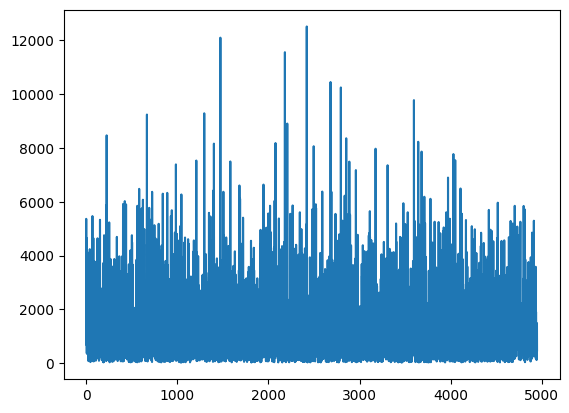

In [61]:
plt.plot(steps_tracker)

In [62]:
S, A, R = agent.generate_trajectory(eps=0.0)
len(S)

1076

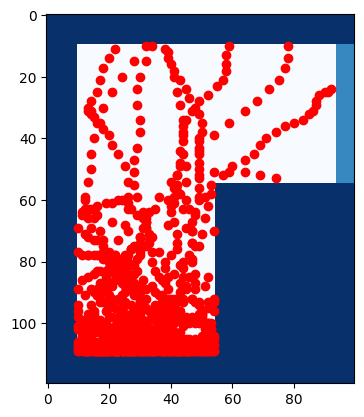

In [63]:
agent_locs = np.array(S)
plt.imshow(racecar_track, cmap='Blues')
plt.scatter(agent_locs[:, 1], agent_locs[:, 0], c='r', marker='o')

In [ ]:
agent_locs = np.array(S)

def animate(iter):
    plt.imshow(racecar_track, cmap='Blues')
    plt.scatter(agent_locs[iter, 1], agent_locs[iter, 0], c='r', marker='o')    

In [ ]:
fig, ax = plt.subplots(1, 1)
anim = animation.FuncAnimation(fig,
                               animate,
                               frames=1000, 
                               interval=1)
HTML(anim.to_jshtml(fps=30))